# 9 epochs

In [91]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from tensorflow.python import keras
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.applications import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input

from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Input
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
import zipfile
import seaborn as sns
from os import listdir, makedirs


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=71e28413bff6cc3734727722729746a961e267b9ddc6055d8ce6825e11077718
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
#import wget
data_url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/7327/861871/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1589312032&Signature=lacicl%2BODFR86lw0g8ZtYuHCTaFzetPI1tL5MzkzqLt4xD%2B38bhji9YeLOVW%2BdI9Fi087WqMD5Nyoh5YV5D7o5nW95c6BeHFZ%2Ff%2BtD8nerQOO9G%2FThlKrTqj%2BRIWZJZr6lRjhIoHioJb056c46tz7YC%2BfD94Av7C5ok8WJ7s%2FHowQMh11DASpowcGBoDe0msWEmc4WAlwEQgCK%2F5chFIzm88BkTbV7yrL1b7tAmjvi36bFQiFRPVfXOUtQX3wvJZIMHeQe7cpayvQaDDNZF9MXti7CpekEUWz3lBEzHOaRe9cEwHKq%2Boli9KsAhP8KuKp3iEJOV2eTWEugCAWIzVSA%3D%3D&response-content-disposition=attachment%3B+filename%3Ddog-breed-identification.zip'
local_zip = '/content/gdrive/My Drive/Dog Breed/Dog-Breed-Identification.zip'
#wget.download(data_url, local_zip)  


In [0]:
data = zipfile.ZipFile(local_zip, 'r')
data.extractall('/content/Dog breed')
data.close()

In [8]:
def append_ext(fn):
    return fn+".jpg"
labels = pd.read_csv('/content/Dog breed/labels.csv', dtype=str)
testdf = pd.read_csv('/content/Dog breed/sample_submission.csv', dtype=str)
print(len(listdir('/content/Dog breed/train')), len(labels))
print(len(listdir('/content/Dog breed/test')), len(testdf))
labels["id"]=labels["id"].apply(append_ext)
testdf["id"]=testdf["id"].apply(append_ext)
labels.head()

10222 10222
10357 10357


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [9]:
#df = pd.read_csv('/content/Dog breed/labels.csv')
breed = labels['breed']
images_name = labels["id"]
classes = pd.get_dummies(breed)
df = pd.concat([images_name,classes], axis=1)
df.head(1)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000bec180eb18c7604dcecc8fe0dba07.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


There are 120 breed


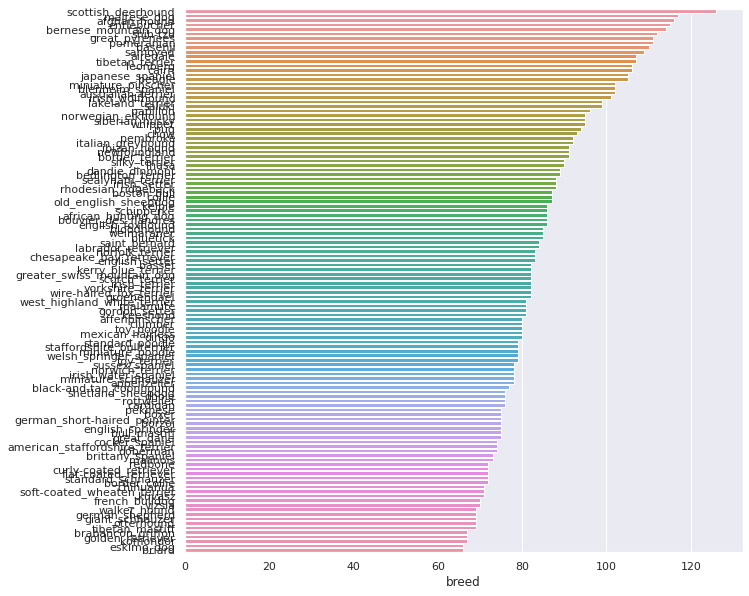

Number of Breed:  120


In [10]:
# Build a dataframe with the number of instances in each class
breed_distrib = labels['breed'].value_counts()
breed_count = len(set(labels['breed']))
breed_distrib.columns = ['breed', 'number']
print(f"There are {breed_count} breed")
# Horizontal bar plot
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.set(font_scale=1)
ax = sns.barplot(breed_distrib,breed_distrib.index)
plt.show()
breed = labels["breed"].unique()
print("Number of Breed: ", len(breed))
breed2id = {name: i for i, name in enumerate(breed)}
id2breed = {i: name for i, name in enumerate(breed)}

In [0]:
datagen = ImageDataGenerator(rescale=1./255.,
                             horizontal_flip=True,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             validation_split=0.2)

In [12]:
image_size = 299
train_dir = '../content/Dog breed/train/'
train_generator=datagen.flow_from_dataframe(
                        dataframe=labels,
                        directory=train_dir,
                        x_col="id",
                        y_col="breed",
                        subset="training",
                        batch_size=8,
                        seed=50,
                        shuffle=True,
                        class_mode="categorical",
                        target_size=(image_size, image_size))


Found 8178 validated image filenames belonging to 120 classes.


In [13]:
train_dir = '../content/Dog breed/train/'

valid_generator=datagen.flow_from_dataframe(
                        dataframe=labels,
                        directory=train_dir,
                        x_col="id",
                        y_col="breed",
                        subset="validation",
                        batch_size=8,
                        seed=42,
                        shuffle=True,
                        class_mode="categorical",
                        target_size=(image_size, image_size))

Found 2044 validated image filenames belonging to 120 classes.


In [14]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_dir = '../content/Dog breed/test/'
test_generator=test_datagen.flow_from_dataframe(
                            dataframe=testdf,
                            directory=test_dir,
                            x_col="id",
                            y_col=None,
                            batch_size=1,
                            seed=42,
                            shuffle=False,
                            class_mode=None,
                            target_size=(image_size, image_size))

Found 10357 validated image filenames.


In [15]:
inputs = Input((299, 299, 3))
backbone = Xception(input_tensor=inputs, include_top=False, weights="imagenet")
backbone.trainable = False
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation="relu")(x)
x = Dense(120, activation="softmax")(x)

model = Model(inputs, x)
lr = 1e-4
optimizer = Adam(lr)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


83689472/83683744 [==============================] - 1s 0us/step


In [16]:
STEP_SIZE_TRAIN=train_generator.n//8
STEP_SIZE_VALID=valid_generator.n//8
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

1022
255


In [17]:
filepath="/content/gdrive/My Drive/Dog Breed/" + "weights.h5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                  shuffle = True, callbacks=callbacks_list)

Epoch 1/10
1022/1022 [==============================] - 376s 368ms/step - loss: 1.6975 - accuracy: 0.6032 - val_loss: 0.8215 - val_accuracy: 0.7799

Epoch 00001: val_loss improved from inf to 0.82149, saving model to /content/gdrive/My Drive/Dog Breed/weights.h5
Epoch 2/10
1022/1022 [==============================] - 359s 352ms/step - loss: 0.5633 - accuracy: 0.8297 - val_loss: 0.7675 - val_accuracy: 0.7888

Epoch 00002: val_loss improved from 0.82149 to 0.76753, saving model to /content/gdrive/My Drive/Dog Breed/weights.h5
Epoch 3/10
1022/1022 [==============================] - 359s 351ms/step - loss: 0.3575 - accuracy: 0.8863 - val_loss: 1.0003 - val_accuracy: 0.7819

Epoch 00003: val_loss did not improve from 0.76753
Epoch 4/10
1022/1022 [==============================] - 360s 352ms/step - loss: 0.2687 - accuracy: 0.9174 - val_loss: 1.6125 - val_accuracy: 0.7829

Epoch 00004: val_loss did not improve from 0.76753
Epoch 5/10
1022/1022 [==============================] - 360s 352ms/ste

In [18]:
scores = model.evaluate_generator(generator=valid_generator)
print("Accuracy = ", scores[1])

Accuracy =  0.7539138793945312


In [19]:
test_generator.reset()
pred=model.predict_generator(test_generator,verbose=1)

10357/10357 [==============================] - 169s 16ms/step


In [0]:
predicted_class_indices=np.argmax(pred,axis=1)
class_labels = (train_generator.class_indices)
class_labels = dict((v,k) for k,v in class_labels.items())
predictions = [class_labels[k] for k in predicted_class_indices]

In [31]:
print(len(predictions) , 'predictions')
filenames=test_generator.filenames
print(len(filenames), 'files')

10357 predictions
10357 files


In [0]:
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("../content/gdrive/My Drive/Dog Breed/results.csv",index=False)

In [92]:
from os.path import join
from keras.applications import Xception
from tensorflow.python.keras.applications.xception import preprocess_input
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

def read_and_prep_image(img_path, img_height=299, img_width=299):
    img = load_img(img_path, target_size=(img_height, img_width))
    img_array = np.array(img_to_array(img))
    output = preprocess_input(img_array)
    output = np.reshape(output,[1,299,299,3])
    return(output)

img_path = '../content/gdrive/My Drive/Dog Breed/test/ne.jpg'
model.load_weights("../content/gdrive/My Drive/Dog Breed/weights.h5")                                     
test_data = read_and_prep_image(img_path)
preds = model.predict(test_data)
print(df.columns[preds.argmax()+1])

norwegian_elkhound
